In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
from yaml import Loader, FullLoader, load
import pickle
from matplotlib import cm
import itertools as it
import networkx as nx
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from pyproj import Proj, transform
from shapely import geometry
import geoplot as gplt
from matplotlib.ticker import FixedLocator

%matplotlib inline

In [21]:
def plot_performance(ax, df, label, metric, color, static=False, H=64, ls='standard', z=1):
    
    df = df.query(f'horizon > 0 & horizon <= {H}')
    h_range = df['horizon'].unique()
    
    if static:
        df = df.groupby('trial').aggregate(np.nanmean).reset_index()
        avg = np.array([np.nanmean(df[metric].values)]*H)
        std = np.array([np.nanstd(df[metric].values)]*H)
        ls = '--' if ls == 'standard' else ls
    else:
        grouped = df.groupby('horizon')        
        avg = grouped[metric].aggregate(np.nanmean).values #[-H:]
        std = grouped[metric].aggregate(np.nanstd).values #[-H:]
        ls = '-' if ls == 'standard' else ls
    
    line = ax.plot(h_range, avg, label=label, ls=ls, color=color, linewidth=1.8, zorder=z)
    ax.fill_between(h_range, avg-std, avg+std, color=color, alpha=0.2, zorder=z)

In [5]:
base_dir = osp.dirname(os.getcwd())
result_dir = osp.join(base_dir, 'results')
output_dir = osp.join(base_dir, 'data', 'plots', 'test_eval')
os.makedirs(output_dir, exist_ok=True)

In [6]:
C, H = 24, 72
test_year = 2017

# load configs for abm and radar experiments
bscale = {}
abm_cfg = osp.join(result_dir, 'abm', 'GBT', f'test_{test_year}', 
                   'final', 'trial_1', 'config.yaml')
with open(abm_cfg) as f:
    config = load(f, Loader=FullLoader)
    bscale['abm'] = config['datasource']['bird_scale']
    
radar_cfg = osp.join(result_dir, 'radar', 'GBT', f'test_{test_year}', 
                     'final', 'trial_1', 'config.yaml')
with open(radar_cfg) as f:
    config = load(f, Loader=FullLoader)
    bscale['radar'] = config['datasource']['bird_scale']

In [7]:
# define baseline models and their labels
baseline_models = {('HA', 'final'): 'HA',
          ('GAM', 'final'): 'GAM',
          ('GBT', 'final'): 'GBT'}
# define FluxRGNN-type models and their labels
flux_models = {    
          ('FluxRGNN', 'final'): 'FluxRGNN', 
          ('LocalLSTM', 'final'): 'w/o fluxes',       
          ('FluxRGNN', 'final_without_encoder'): 'w/o encoder',
          ('FluxRGNN', 'final_without_boundary'): 'w/o boundary'}
# define colors
baseline_colors = ['#cccccc', '#999999', '#404040']
baseline_ls = ['--', '-.', ':']
flux_colors = ['#ff7f00', '#b30000', '#999966', '#008080']

### ***Predictive performance***

#### Simulated data

In [8]:
rmse_per_hour = pd.read_csv(osp.join(result_dir, 'abm', 
                'performance_evaluation', 'ablations', 'rmse_per_hour.csv'))
rmse_per_hour['rmse'] = rmse_per_hour['rmse'] / bscale['abm']
grouped = rmse_per_hour.query('horizon == 24').groupby(['model', 'experiment'])
means = grouped.rmse.aggregate(np.nanmean)
stds = grouped.rmse.aggregate(np.nanstd)
print('######## RMSE at H=24h #######')
print(means, stds, '\n')

pcc_per_hour = pd.read_csv(osp.join(result_dir, 'abm', 
                'performance_evaluation', 'ablations', 'pcc_per_hour.csv'))
grouped = pcc_per_hour.query('horizon == 24').groupby(['model', 'experiment'])
means = grouped.pcc.aggregate(np.nanmean)
stds = grouped.pcc.aggregate(np.nanstd)
print('######## PCC at H=24h #######')
print(means, stds)

######## RMSE at H=24h #######
model      experiment            
FluxRGNN   final                     0.025899
           final_without_boundary    0.027224
           final_without_encoder     0.027555
LocalLSTM  final                     0.029274
Name: rmse, dtype: float64 model      experiment            
FluxRGNN   final                     0.000266
           final_without_boundary    0.000556
           final_without_encoder     0.000697
LocalLSTM  final                     0.000316
Name: rmse, dtype: float64 

######## PCC at H=24h #######
model      experiment            
FluxRGNN   final                     0.534891
           final_without_boundary    0.516622
           final_without_encoder     0.447179
LocalLSTM  final                     0.345907
Name: pcc, dtype: float64 model      experiment            
FluxRGNN   final                     0.011739
           final_without_boundary    0.030941
           final_without_encoder     0.031712
LocalLSTM  final               

best trial (rmse): 2
best trial (pcc) : 2


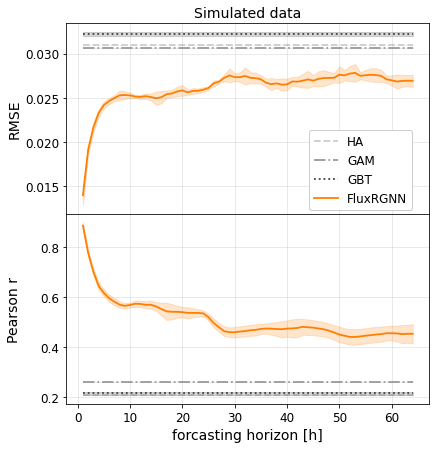

In [22]:
fig, ax = plt.subplots(nrows=2, figsize=(6.5,7), sharex=True)

baseline_rmse = pd.read_csv(osp.join(result_dir, 'abm', 
                'performance_evaluation', 'final', 'rmse_per_hour.csv'))
baseline_pcc = pd.read_csv(osp.join(result_dir, 'abm', 
                'performance_evaluation', 'final', 'pcc_per_hour.csv'))

baseline_rmse['rmse'] /= bscale['abm']

rmse_per_hour = pd.read_csv(osp.join(result_dir, 'abm', 
                'performance_evaluation', 'ablations', 'rmse_per_hour.csv'))
pcc_per_hour = pd.read_csv(osp.join(result_dir, 'abm', 
                'performance_evaluation', 'ablations', 'pcc_per_hour.csv'))
rmse_per_hour['rmse'] /= bscale['abm']

df = rmse_per_hour.query('model == "FluxRGNN" & experiment == "final"')
best_t = df.groupby('trial')['rmse'].aggregate(np.nanmean).idxmin()
print(f'best trial (rmse): {best_t}')

df = pcc_per_hour.query('model == "FluxRGNN" & experiment == "final"')
best_t = df.groupby('trial')['pcc'].aggregate(np.nanmean).idxmax()
print(f'best trial (pcc) : {best_t}')

for i, ((m, e), label) in enumerate(baseline_models.items()):
    plot_performance(ax[0], baseline_rmse.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, 'rmse', static=True, H=H, 
                     color=baseline_colors[i], ls=baseline_ls[i])
    plot_performance(ax[1], baseline_pcc.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, 'pcc', static=True, H=H, 
                     color=baseline_colors[i], ls=baseline_ls[i])

for i, ((m, e), label) in enumerate(flux_models.items()):
    if m == 'FluxRGNN' and e == 'final':
        plot_performance(ax[0], rmse_per_hour.query(f'model == "{m}" & experiment == "{e}"'), 
                         label, 'rmse', static=False, H=H, color=flux_colors[i])
        plot_performance(ax[1], pcc_per_hour.query(f'model == "{m}" & experiment == "{e}"'), 
                         label, 'pcc', static=False, H=H, color=flux_colors[i])


    
ax[0].set_ylabel('RMSE', fontsize=14)
ax[1].set_ylabel('Pearson r', fontsize=14)
ax[1].set_xlabel('forcasting horizon [h]', fontsize=14)
ax[1].legend(loc='upper right', fontsize=12, 
            bbox_to_anchor=(0.97,1.47), framealpha=1)
ax[0].set_title('Simulated data', fontsize=14)

for axis in ax:
    axis.tick_params(axis='both', which='major', labelsize=12)
    axis.grid(color = 'gray', linestyle = '-', alpha=0.2)

fig.subplots_adjust(wspace=0.25, hspace=0)
fig.align_ylabels(ax)
fig.savefig(osp.join(output_dir, 'abm_rmse_pcc_per_hour.png'), bbox_inches='tight', dpi=200)

#### Radar data

In [11]:
rmse_per_hour = pd.read_csv(osp.join(result_dir, 'radar', 
                'performance_evaluation', 'ablations', 'rmse_per_hour.csv'))
rmse_per_hour['rmse'] = rmse_per_hour['rmse'] / bscale['radar']
grouped = rmse_per_hour.query('horizon == 24').groupby(['model', 'experiment'])
means = grouped.rmse.aggregate(np.nanmean)
stds = grouped.rmse.aggregate(np.nanstd)
print('######## RMSE at H=24h #######')
print(means, stds, '\n')

pcc_per_hour = pd.read_csv(osp.join(result_dir, 'radar', 
                'performance_evaluation', 'ablations', 'pcc_per_hour.csv'))
grouped = pcc_per_hour.query('horizon == 24').groupby(['model', 'experiment'])
means = grouped.pcc.aggregate(np.nanmean)
stds = grouped.pcc.aggregate(np.nanstd)
print('######## PCC at H=24h #######')
print(means, stds)

######## RMSE at H=24h #######
model      experiment            
FluxRGNN   final                     0.018804
           final_without_boundary    0.022110
           final_without_encoder     0.019639
LocalLSTM  final                     0.018424
Name: rmse, dtype: float64 model      experiment            
FluxRGNN   final                     0.000238
           final_without_boundary    0.000708
           final_without_encoder     0.000293
LocalLSTM  final                     0.000565
Name: rmse, dtype: float64 

######## PCC at H=24h #######
model      experiment            
FluxRGNN   final                     0.732663
           final_without_boundary    0.718182
           final_without_encoder     0.691681
LocalLSTM  final                     0.741740
Name: pcc, dtype: float64 model      experiment            
FluxRGNN   final                     0.006480
           final_without_boundary    0.019567
           final_without_encoder     0.014972
LocalLSTM  final               

best trial (rmse): 1
best trial (pcc) : 1


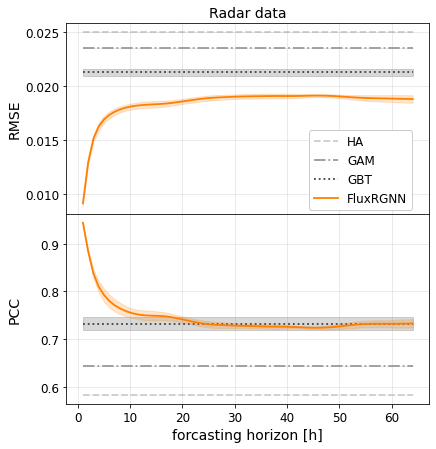

In [23]:
fig, ax = plt.subplots(nrows=2, figsize=(6.5,7), sharex=True)

baseline_rmse = pd.read_csv(osp.join(result_dir, 'radar', 
                'performance_evaluation', 'final', 'rmse_per_hour.csv'))
baseline_pcc = pd.read_csv(osp.join(result_dir, 'radar', 
                'performance_evaluation', 'final', 'pcc_per_hour.csv'))
baseline_rmse['rmse'] /= bscale['radar']

pcc_per_hour = pd.read_csv(osp.join(result_dir, 'radar', 
                'performance_evaluation', 'ablations', 'pcc_per_hour.csv'))
rmse_per_hour = pd.read_csv(osp.join(result_dir, 'radar', 
                'performance_evaluation', 'ablations', 'rmse_per_hour.csv'))
rmse_per_hour['rmse'] = rmse_per_hour['rmse'] / bscale['radar']

df = rmse_per_hour.query('model == "FluxRGNN" & experiment == "final"')
best_t = df.groupby('trial')['rmse'].aggregate(np.nanmean).idxmin()
print(f'best trial (rmse): {best_t}')

df = pcc_per_hour.query('model == "FluxRGNN" & experiment == "final"')
best_t = df.groupby('trial')['pcc'].aggregate(np.nanmean).idxmax()
print(f'best trial (pcc) : {best_t}')

for i, ((m, e), label) in enumerate(baseline_models.items()):
    plot_performance(ax[0], baseline_rmse.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, 'rmse', static=True, H=H, 
                     color=baseline_colors[i], ls=baseline_ls[i])
    plot_performance(ax[1], baseline_pcc.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, 'pcc', static=True, H=H, 
                     color=baseline_colors[i], ls=baseline_ls[i])

for i, ((m, e), label) in enumerate(flux_models.items()):
    if m == 'FluxRGNN' and e == 'final':
        plot_performance(ax[0], rmse_per_hour.query(f'model == "{m}" & experiment == "{e}"'), 
                         label, 'rmse', static=False, H=H, color=flux_colors[i])
        plot_performance(ax[1], pcc_per_hour.query(f'model == "{m}" & experiment == "{e}"'), 
                         label, 'pcc', static=False, H=H, color=flux_colors[i])


ax[0].set_ylabel('RMSE', fontsize=14)
ax[1].set_ylabel('PCC', fontsize=14)
ax[1].set_xlabel('forcasting horizon [h]', fontsize=14)
ax[1].legend(loc='upper right', fontsize=12, 
            bbox_to_anchor=(0.97,1.47), framealpha=1)
ax[0].set_title('Radar data', fontsize=14)

for axis in ax:
    axis.tick_params(axis='both', which='major', labelsize=12)
    axis.grid(color = 'gray', linestyle = '-', alpha=0.2)

fig.subplots_adjust(wspace=0.25, hspace=0)
fig.align_ylabels(ax)
fig.savefig(osp.join(output_dir, 'radar_rmse_pcc_per_hour.png'), bbox_inches='tight', dpi=200)

### ***Ablation study***

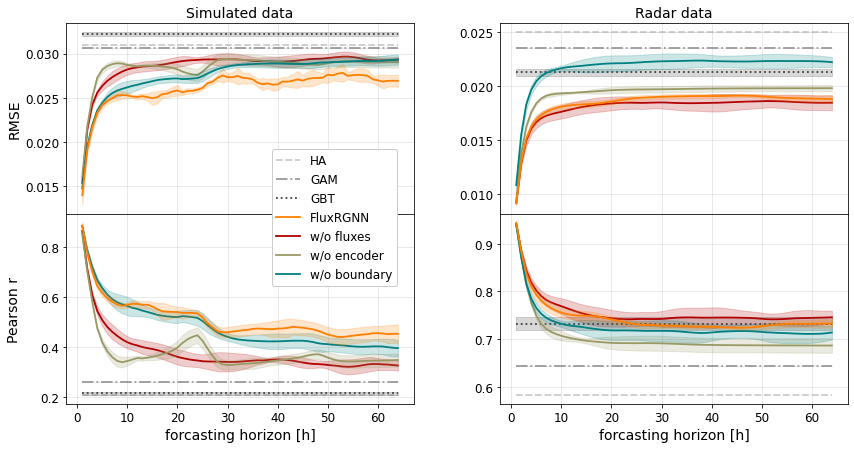

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,7), sharex=True)

for i, datasource in enumerate(['abm', 'radar']):
    
    # load baseline performance
    baseline_rmse = pd.read_csv(osp.join(result_dir, datasource, 
                    'performance_evaluation', 'final', 'rmse_per_hour.csv'))
    baseline_pcc = pd.read_csv(osp.join(result_dir, datasource, 
                    'performance_evaluation', 'final', 'pcc_per_hour.csv'))
    baseline_rmse['rmse'] /= bscale[datasource]
    
    # load FluxRGNN performance
    rmse_per_hour = pd.read_csv(osp.join(result_dir, datasource, 
                    'performance_evaluation', 'ablations', 'rmse_per_hour.csv'))
    pcc_per_hour = pd.read_csv(osp.join(result_dir, datasource, 
                    'performance_evaluation', 'ablations', 'pcc_per_hour.csv'))
    rmse_per_hour['rmse'] /= bscale[datasource]


    for j, ((m, e), label) in enumerate(baseline_models.items()):
        plot_performance(ax[0, i], baseline_rmse.query(f'model == "{m}" & experiment == "{e}"'), 
                         label, 'rmse', static=True, H=H, 
                         color=baseline_colors[j], ls=baseline_ls[j])
        plot_performance(ax[1, i], baseline_pcc.query(f'model == "{m}" & experiment == "{e}"'), 
                         label, 'pcc', static=True, H=H, 
                         color=baseline_colors[j], ls=baseline_ls[j])

    for j, ((m, e), label) in enumerate(flux_models.items()):
        if m == 'FluxRGNN' and e == 'final':
            z = 2
        else:
            z = 1
        plot_performance(ax[0, i], rmse_per_hour.query(f'model == "{m}" & experiment == "{e}"'), 
                         label, 'rmse', static=False, H=H, color=flux_colors[j], z=z)
        plot_performance(ax[1, i], pcc_per_hour.query(f'model == "{m}" & experiment == "{e}"'), 
                         label, 'pcc', static=False, H=H, color=flux_colors[j], z=z)

    ax[1,i].set_xlabel('forcasting horizon [h]', fontsize=14)
    
ax[0,0].set_ylabel('RMSE', fontsize=14)
ax[1,0].set_ylabel('Pearson r', fontsize=14)
ax[1,0].legend(loc='upper right', fontsize=12, 
            bbox_to_anchor=(0.97,1.37), framealpha=1)
ax[0,0].set_title('Simulated data', fontsize=14)
ax[0,1].set_title('Radar data', fontsize=14)

for axis in ax.flatten():
    axis.tick_params(axis='both', which='major', labelsize=12)
    axis.grid(color = 'gray', linestyle = '-', alpha=0.2)

fig.subplots_adjust(wspace=0.25, hspace=0)
fig.align_ylabels(ax)
fig.savefig(osp.join(output_dir, 'rmse_pcc_per_hour_combined.png'), bbox_inches='tight', dpi=200)

### **Intra-night performance**

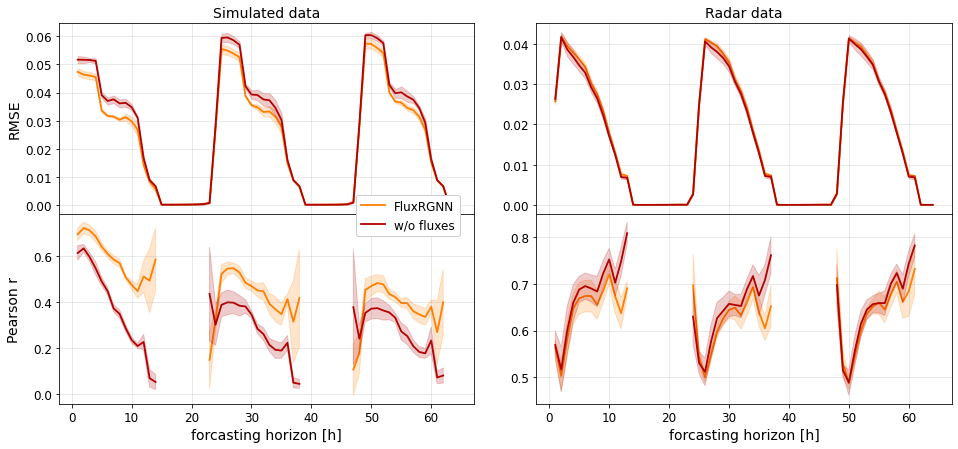

In [19]:
H=64

fixed_t0 = True
ext = '_fixedT0' if fixed_t0 else ''

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,7), sharex=True)

for i, datasource in enumerate(['abm', 'radar']):
    
    # load baseline performance
    baseline_rmse = pd.read_csv(osp.join(result_dir, datasource, 
                    f'performance_evaluation{ext}', 'final', 'rmse_per_hour.csv'))
    baseline_pcc = pd.read_csv(osp.join(result_dir, datasource, 
                    f'performance_evaluation{ext}', 'final', 'pcc_per_hour.csv'))
    baseline_rmse['rmse'] /= bscale[datasource]
    
    # load FluxRGNN performance
    rmse_per_hour = pd.read_csv(osp.join(result_dir, datasource, 
                    f'performance_evaluation{ext}', 'ablations', 'rmse_per_hour.csv'))
    pcc_per_hour = pd.read_csv(osp.join(result_dir, datasource, 
                    f'performance_evaluation{ext}', 'ablations', 'pcc_per_hour.csv'))
    rmse_per_hour['rmse'] /= bscale[datasource]

    for j, ((m, e), label) in enumerate(flux_models.items()):
        if e == 'final':
            plot_performance(ax[0, i], rmse_per_hour.query(f'model == "{m}" & experiment == "{e}"'), 
                             label, 'rmse', H=H, color=flux_colors[j], z=z)
            plot_performance(ax[1, i], pcc_per_hour.query(f'model == "{m}" & experiment == "{e}"'), 
                             label, 'pcc', H=H, color=flux_colors[j], z=z)

    ax[1,i].set_xlabel('forcasting horizon [h]', fontsize=14)
    
ax[0,0].set_ylabel('RMSE', fontsize=14)
ax[1,0].set_ylabel('Pearson r', fontsize=14)
ax[1,0].legend(loc='upper right', fontsize=12, 
            bbox_to_anchor=(0.98,1.13), 
               framealpha=1)
ax[0,0].set_title('Simulated data', fontsize=14)
ax[0,1].set_title('Radar data', fontsize=14)

for axis in ax.flatten():
    axis.tick_params(axis='both', which='major', labelsize=12)
    axis.grid(color = 'gray', linestyle = '-', alpha=0.2)

fig.subplots_adjust(wspace=0.15, hspace=0)
fig.align_ylabels(ax)
fig.savefig(osp.join(output_dir, f'rmse_pcc_per_hour_combined{ext}.png'), bbox_inches='tight', dpi=200)